In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
import socketio
import eventlet

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Corrected import for matplotlib
from random import shuffle  # Import shuffle
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random
import os

def getName(filePath):
    return filePath.split('\\')[-1]  # Use single backslash


def ImportDataInfo(path):
    columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=columns)

    # Remove file path and get only file name
    data['center'] = data['center'].apply(getName)

    print("Total Images Imported:", data.shape[0])
    return data


def balanceData(data, display=True):
    nBin = 31
    samplesPerBin = 500
    hist, bins = np.histogram(data['steering'], nBin)

    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['steering']), np.max(data['steering'])), (samplesPerBin, samplesPerBin))
        plt.xlabel('steering Angle')
        plt.ylabel('Number of Samples')
        plt.title('Distribution of steering Angles Before Balancing')
        plt.show()

    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['steering'])):
            if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
                binDataList.append(i)

        shuffle(binDataList)  # Shuffle the bin data in place

        # Keep only samples above the limit
        binDataList = binDataList[samplesPerBin:]  # This will now work correctly

        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))

    if display:
        hist, _ = np.histogram(data['steering'], nBin)
        center = (bins[:-1] + bins[1:]) * 0.5  # Calculate center for new histogram
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['steering']), np.max(data['steering'])), (samplesPerBin, samplesPerBin))
        plt.xlabel('steering Angle')
        plt.ylabel('Number of Samples')
        plt.title('Distribution of steering Angles After Balancing')
        plt.show()


# Specify your path to the CSV file
data_path = 'C:\\Users\\harsh\\PycharmProjects\\pythonProject\\pythonProject1\\myData'  # Update this path

# Call the functions
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(os.path.join(path, 'IMG', getName(indexed_data['center'])))
    steering.append(float(indexed_data['steering']))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering


def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img,steering

def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img


def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
          index = random.randint(0, len(imagesPath) - 1)
          if trainFlag:
             img, steering = augmentImage(imagesPath[index], steeringList[index])
          else:
             img = mpimg.imread(imagesPath[index])
             steering = steeringList[index]
          img = preProcess(img)
          imgBatch.append(img)
          steeringBatch.append(steering)
        yield (np.asarray(imgBatch), np.asarray(steeringBatch))


In [10]:
def createModel():
  model = Sequential()
 
  model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
 
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
 
  model.compile(Adam(learning_rate=0.0001),loss='mse')
  return model


Total Images Imported: 3930
Total Images Imported: 3930


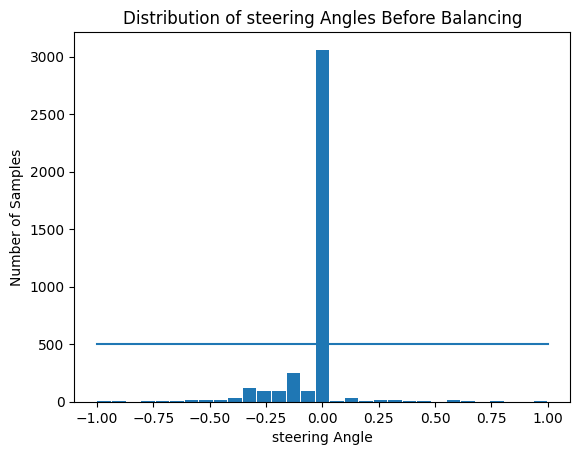

Removed Images: 2561
Remaining Images: 1369


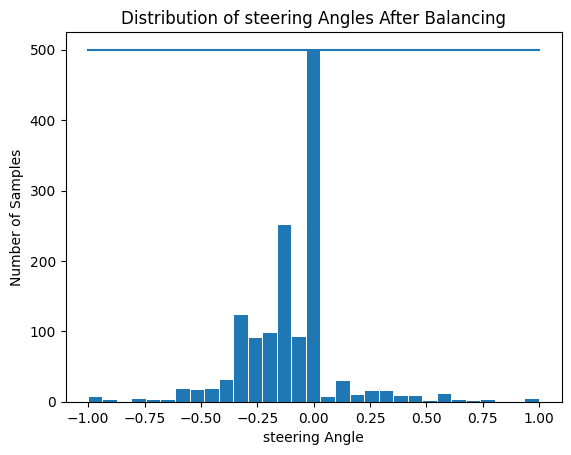

Total Training Images:  1095
Total Validation Images:  274
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                             

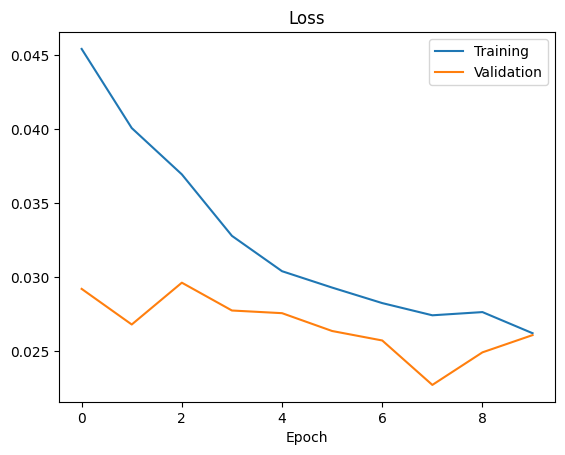

In [11]:
from sklearn.model_selection import train_test_split

path = r'C:\Users\harsh\PycharmProjects\pythonProject\pythonProject1\myData'
data = ImportDataInfo(path)

data = ImportDataInfo(data_path)
balanceData(data)

imagesPath, steerings = loadData(path,data)

xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

model = createModel()
model.summary()

history = model.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=200)
model.save('model.h5')
print('Model Saved')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()


In [ ]:
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import socketio
import eventlet
import numpy as np
from flask import Flask
from tensorflow.keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2
 
#### FOR REAL TIME COMMUNICATION BETWEEN CLIENT AND SERVER
sio = socketio.Server()
#### FLASK IS A MICRO WEB FRAMEWORK WRITTEN IN PYTHON
app = Flask(__name__)  # '__main__'
 
maxSpeed = 10
 
 
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
 
 
@sio.on('telemetry')
def telemetry(sid, data):
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = preProcess(image)
    image = np.array([image])
    steering = float(model.predict(image))
    throttle = 1.0 - speed / maxSpeed
    print(f'{steering}, {throttle}, {speed}')
    sendControl(steering, throttle)
 
 
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    sendControl(0, 0)
 
 
def sendControl(steering, throttle):
    sio.emit('steer', data={
        'steering_angle': steering.__str__(),
        'throttle': throttle.__str__()
    })
 
 
if __name__ == '__main__':
    model = load_model('model.h5')
    app = socketio.Middleware(sio, app)
    ### LISTEN TO PORT 4567
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

Setting UP


(13152) wsgi starting up on http://0.0.0.0:4567
(13152) accepted ('127.0.0.1', 52225)
